# StyleGAN on custom images

Let's first understand a few historical developments prior to the invention
of StyleGAN. As we know, generating fake faces from the previous chapter involved
the usage of GANs. The biggest problem that research faced was that the images that
could be generated were small (typically 64 x 64). And any effort to generate images
of a larger size caused the generators or discriminators to fall into local minima that
would stop training and generate gibberish. One of the major leaps in generating
high-quality images involved a research paper called ProGAN (short for Progressive
GAN), which involved a clever trick.

The size of both the generator and discriminator is progressively increased. In the
first step, you create a generator and discriminator to generate 4 x 4 images from a
latent vector. After this, additional convolution (and upscaling) layers are added to
the trained generator and discriminator, which will be responsible for accepting the 4
x 4 images (which are generated from latent vectors in step 1) and
generating/discriminating 8 x 8 images. Once this step is also done, new layers are
created in the generator and discriminator once again, to be trained to generate larger
images. Step by step (progressively), the image size is increased in this way. The logic
being that it is easier to add a new layer to an already well functioning network than
trying to learn all the layers from scratch. In this manner, images are upscaled to a
resolution of 1024 x 1024 pixels

![image.png](./imgs/gan3.png)

StyleGAN uses a similar training scheme where images are progressively generated,
but with an added set of latent inputs every time the network grows. This means the
network now accepts multiple latent vectors at regular intervals of image size
generated. Every latent given at a stage of generation dictates the features (style) that
are going to be generated at that stage of that network. Let's discuss the working
details of StyleGAN in more detail here:

![image.png](./imgs/gan4.png)

In the preceding diagram, we can contrast the traditional way of generating images
and the style-based generator. In a traditional generator, there is only one input.
However, there is a mechanism in place within a style-based generator. Let's
understand the details here:

1. Create a random noise vector z of size 1 x 512.
2. Feed this to an auxiliary network called the style network (or mapping
network), which creates a tensor w of size 18 x 512.
3. The generator (synthesis) network contains 18 convolution layers. Each
layer will accept the following as inputs:
    
    - The corresponding row of w ('A')
    
    - A random noise vector ('B')
    
    - The output from the previous layer

Note that noise ('B') is given only for regularization purposes.

The preceding three combined will create a pipeline that takes in a 1 x 512 vector and
creates a 1024 x 1024 image.

Let's now understand how each of the 18 1 x 512 vectors within the 18 x 512 vector
that is generated from the mapping network contributes towards the generation of an
image. The 1 x 512 vector that is added at the first few layers of the synthesis network
contributes towards the overall pose and large-scale features present in the image,
such as pose, face shape, and so on, (as they are responsible for generating the 4 x 4, 8
x 8 images, and so on – which are the first few images that will be further enhanced in
the later layers). The vectors added in the middle layers correspond to small-scale
features such as hairstyle, eyes open/closed (as they are responsible for generating the
16 x 16, 32 x 32, and 64 x 64 images). The vectors added in the last few layers
correspond to the color scheme and other microstructures of the image. By the time
we reach the last few layers, the image structure is preserved, and the facial features
are preserved but only image-level details such as lighting conditions are changed.

In this notebook, we will leverage a pre-trained StyleGAN2 model to customize our
image of interest to have different styles.

For our objective, we will perform style transfer using the StyleGAN2 model. At a
high level, here's how style-transfer on faces works (the following will be clearer as
you go through the results of the code):

- Say the $w_1$ style vector is used to generate face-1 and the $w_2$ style vector is
used to generate face-2. Both of them are 18 x 512.

- The first few of the 18 vectors in $w_2$ (which are responsible for generating
images from 4 x 4 to 8 x 8 resolutions) are replaced with the corresponding
vectors from $w_1$ . Then, we transfer very coarse features such as the pose
from face-1 to face-2.

- If the later style vectors (say the third to the fifteenth of the 18 x 512 – which
are responsible for generating 64 x 64 to 256 x 256 dimensional batch of
images) are replaced in $w_2$ with those from $w_1$ , then we transfer features
such as eyes, nose, and other facial mid-level features.

- If the last few style vectors (which are responsible for generating 512 x 512
to 1024 x 1024 dimensional batch of images) are replaced, fine-level features
such as complexion and background (which don't affect the overall face in
a significant manner) are transferred.

With an understanding of how style transfer is done, let's now understand how to
perform style transfer using StyleGAN2 on custom images:

1. Take a custom image.

2. Align the custom image so that only the face region of the image is stored.

3. Fetch the latent vector that is likely to generate the custom aligned image.

4. Generate an image by passing a random latent vector (1 x 512) to the
mapping network.

In [ ]:
import os
if not os.path.exists('pytorch_stylegan_encoder'):
    !git clone https://github.com/jacobhallberg/pytorch_stylegan_encoder.git
    %cd pytorch_stylegan_encoder
    !git submodule update --init --recursive
    !wget -q https://github.com/jacobhallberg/pytorch_stylegan_encoder/releases/download/v1.0/trained_models.zip
    !unzip -q trained_models.zip
    !rm trained_models.zip
    !pip install -qU torch_snippets
    !mv trained_models/stylegan_ffhq.pth InterFaceGAN/models/pretrain
else:
    %cd pytorch_stylegan_encoder
    
from torch_snippets import *

Cloning into 'pytorch_stylegan_encoder'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 358 (delta 40), reused 15 (delta 6), pack-reused 287
Receiving objects: 100% (358/358), 56.89 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/pytorch_stylegan_encoder
Submodule 'InterFaceGAN' (git://github.com/ShenYujun/InterFaceGAN.git) registered for path 'InterFaceGAN'
Cloning into '/content/pytorch_stylegan_encoder/InterFaceGAN'...
Submodule path 'InterFaceGAN': checked out 'b707e942187f464251f855c92f7009b8cf13bf03'
     |████████████████████████████████| 36.7MB 82kB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 


In [ ]:
from InterFaceGAN.models.stylegan_generator import StyleGANGenerator
from models.latent_optimizer import PostSynthesisProcessing

synthesizer = StyleGANGenerator("stylegan_ffhq").model.synthesis
mapper = StyleGANGenerator("stylegan_ffhq").model.mapping
trunc = StyleGANGenerator("stylegan_ffhq").model.truncation

[2020-10-13 05:39:11,237][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 05:39:11,514][INFO] Successfully loaded!
[2020-10-13 05:39:11,516][INFO]   `lod` of the loaded model is 0.0.
[2020-10-13 05:39:21,174][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 05:39:21,438][INFO] Successfully loaded!
[2020-10-13 05:39:21,439][INFO]   `lod` of the loaded model is 0.0.
[2020-10-13 05:39:21,693][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 05:39:21,926][INFO] Successfully loaded!
[2020-10-13 05:39:21,927][INFO]   `lod` of the loaded model is 0.0.


In [ ]:
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)[0]

def latent2image(latent):
    img = post_process(synthesizer(latent))
    img = img.transpose(1,2,0)
    return img

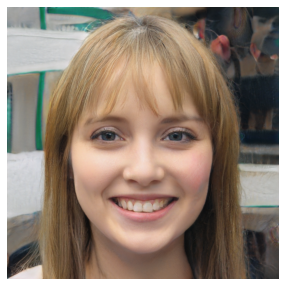

In [ ]:
rand_latents = torch.randn(1,512).cuda()
show(latent2image(trunc(mapper(rand_latents))), sz=5)

In [ ]:
!wget -q https://www.dropbox.com/s/lpw10qawsc5ipbn/MyImage.JPG -O MyImage.jpg
!git clone https://github.com/sizhky/stylegan-encoder.git
!mkdir -p stylegan-encoder/raw_images
!mkdir -p stylegan-encoder/aligned_images
!mv MyImage.jpg stylegan-encoder/raw_images

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 105, done.
remote: Total 105 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (105/105), 10.39 MiB | 10.51 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
!python stylegan-encoder/align_images.py stylegan-encoder/raw_images/ stylegan-encoder/aligned_images/
!mv stylegan-encoder/aligned_images/* ./MyImage.jpg

2020-10-13 05:42:04.958242: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
64045056/64040097 [==============================] - 38s 1us/step


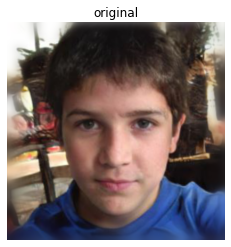

Optimizing Latents.
[2020-10-13 05:54:26,513][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 05:54:26,773][INFO] Successfully loaded!
[2020-10-13 05:54:26,773][INFO]   `lod` of the loaded model is 0.0.
Step: 2999, Loss: 1.732578992843628: 100% 3000/3000 [11:01<00:00,  4.53it/s]


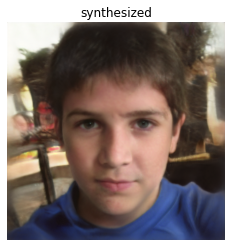

In [ ]:
from PIL import Image
img = Image.open('MyImage.jpg')
show(np.array(img), sz=4, title='original')

!python encode_image.py ./MyImage.jpg\
    pred_dlatents_myImage.npy\
    --use_latent_finder true\
    --image_to_latent_path ./trained_models/image_to_latent.pt

pred_dlatents = np.load('pred_dlatents_myImage.npy')
pred_dlatent = torch.from_numpy(pred_dlatents).float().cuda()
pred_image = latent2image(pred_dlatent)
show(pred_image, sz=4, title='synthesized')

2020-10-13 06:13:42.436 | INFO     | torch_snippets.loader:subplots:359 - plotting 4 images in a grid of 2x2 @ (7, 8)


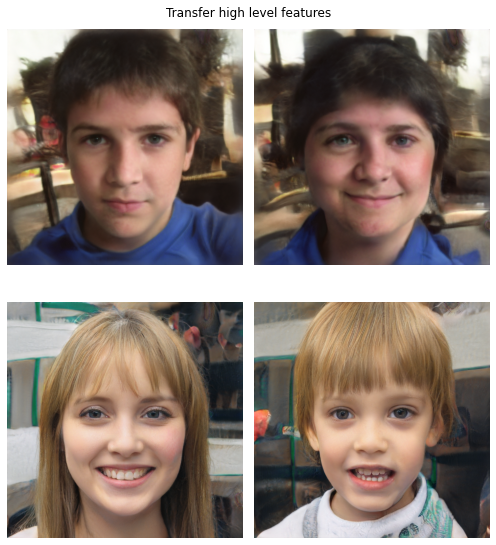

In [ ]:
idxs_to_swap = slice(0,3)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer high level features')

In [ ]:
idxs_to_swap

slice(0, 2, None)

2020-10-13 06:13:52.663 | INFO     | torch_snippets.loader:subplots:359 - plotting 4 images in a grid of 2x2 @ (7, 8)


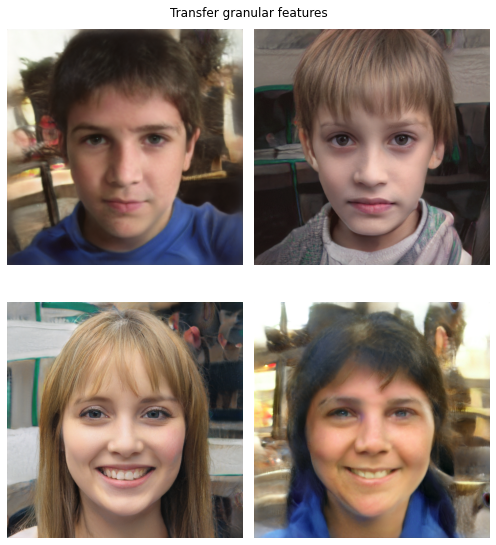

In [ ]:
idxs_to_swap = slice(4,15)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer granular features')

2020-10-13 06:14:10.776 | INFO     | torch_snippets.loader:subplots:359 - plotting 4 images in a grid of 2x2 @ (7, 8)


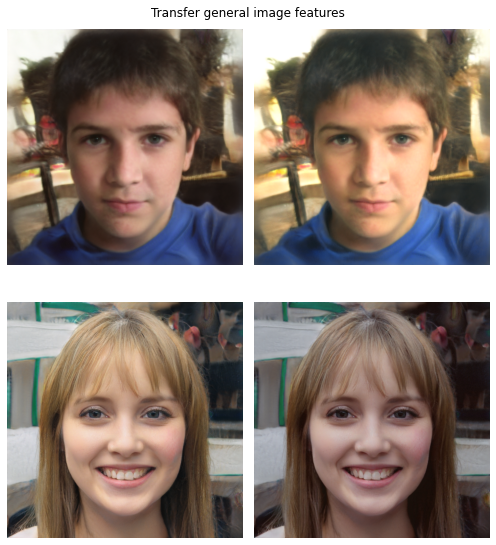

In [ ]:
idxs_to_swap = slice(16,18)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer general image features')

[2020-10-13 06:17:20,651][INFO] Initializing generator.
[2020-10-13 06:17:20,887][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 06:17:21,161][INFO] Successfully loaded!
[2020-10-13 06:17:21,161][INFO]   `lod` of the loaded model is 0.0.
[2020-10-13 06:17:24,246][INFO] Preparing boundary.
[2020-10-13 06:17:24,250][INFO] Preparing latent codes.
[2020-10-13 06:17:24,250][INFO]   Load latent codes from `pred_dlatents_myImage.npy`.
[2020-10-13 06:17:24,251][INFO] Editing 1 samples.
[2020-10-13 06:17:26,461][INFO] Successfully edited 1 samples.


2020-10-13 06:17:26.979 | INFO     | torch_snippets.loader:subplots:359 - plotting 20 images in a grid of 4x5 @ (10, 10)


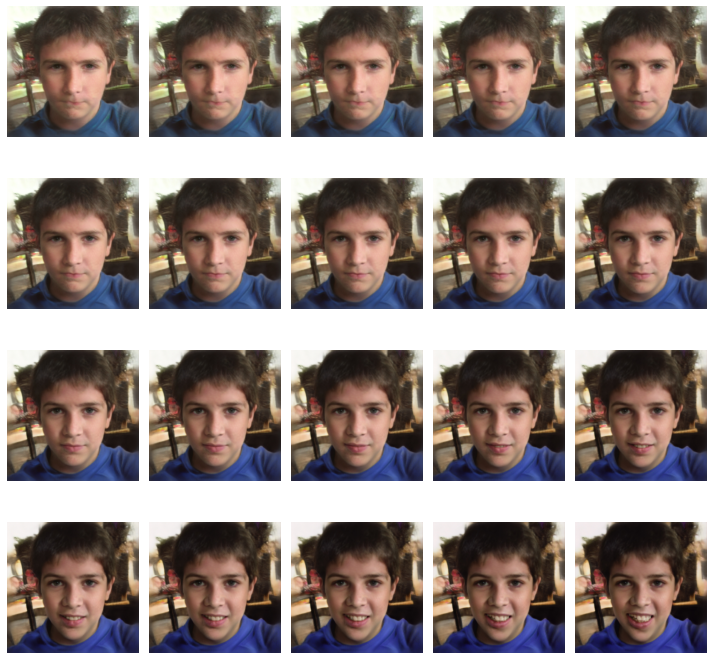

In [ ]:
!python InterFaceGAN/edit.py\
 -m stylegan_ffhq\
 -o results_new_smile\
 -b InterFaceGAN/boundaries/stylegan_ffhq_smile_w_boundary.npy\
 -i pred_dlatents_myImage.npy\
 -s WP\
 --steps 20

generated_faces = glob.glob('results_new_smile/*.jpg')

subplots([read(im,1) for im in sorted(generated_faces)],figsize=(10,10))